In [1]:
%load_ext autoreload
%autoreload 2

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from scipy.stats import entropy
import time
import os
import copy
import sys
import gc
sys.path.append('./python_files')

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_models import *

#!pip install Pillow==5.0.0

import numpy as np

data_dir = './data/imagenet/'
class_file = 'class_ids.txt'
TRAIN = 'uniform_training'
VAL = 'uniform_test'
TEST = 'uniform_val'

from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  1.0.0


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


In [4]:
# VGG-16 Takes 224x224 images as input, so we resize all of them
def load_imagenet(data_dir, batch_size=8, shuffle=True, num_workers=1, pin_memory=True):
    data_transforms = {
        TRAIN: transforms.Compose([
            # Data augmentation is a good practice for the train set
            # Here, we randomly crop the image to 224x224 and
            # randomly flip it horizontally.
            transforms.Resize(224),
            transforms.CenterCrop(224),
            #transforms.RandomResizedCrop(224),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]),
        TEST: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    }

    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x), 
            transform=data_transforms[x],
        )
        for x in [TRAIN, TEST]
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size=batch_size,
            shuffle=shuffle, num_workers=num_workers,
            pin_memory=pin_memory
        )
        for x in [TRAIN, TEST]
    }
    
    class_names = image_datasets[TRAIN].classes

    dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

    for x in [TRAIN, TEST]:
        print("Loaded {} images under {}".format(dataset_sizes[x], x))
        
    return image_datasets, dataloaders, dataset_sizes, class_names

#print("Classes: ")

#print(image_datasets[TRAIN].classes)

In [5]:
image_datasets, dataloaders, dataset_sizes, class_names = load_imagenet(data_dir,
                           32, #batch_size
                           shuffle=True,
                           num_workers=1,
                           pin_memory=False)

Loaded 10000 images under uniform_training
Loaded 10000 images under uniform_val


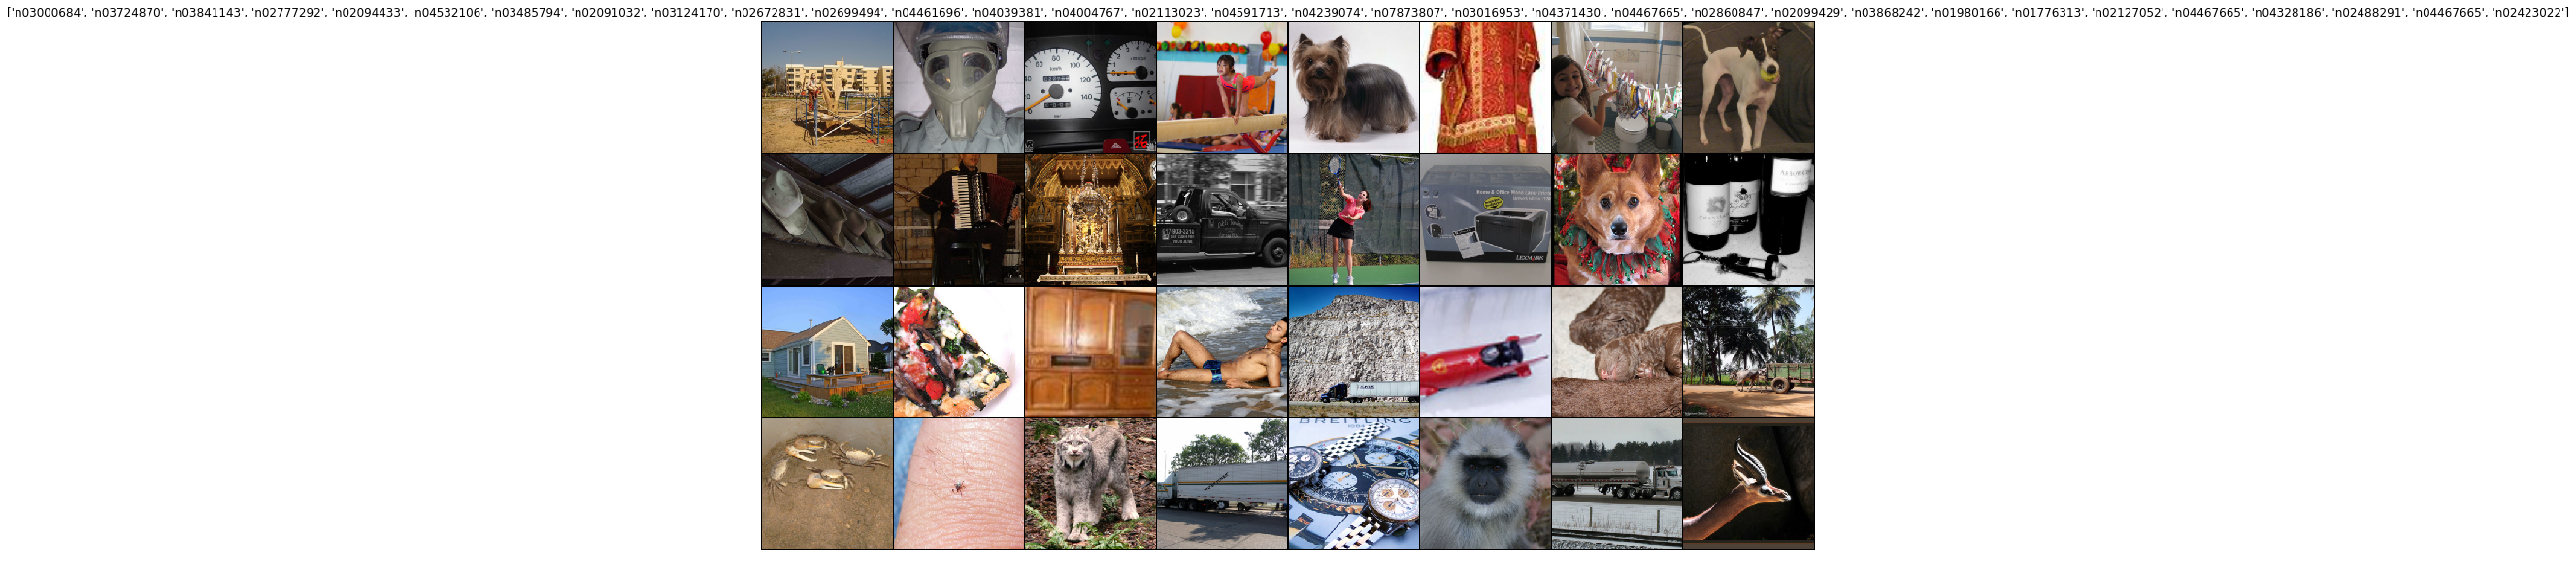

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(30, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])
    
def visualize_model(vgg, num_images=6):
    
    with torch.no_grad():
        vgg.eval()
        images_so_far = 0

        for i, data in enumerate(dataloaders[TEST]):
            inputs, labels = data
            size = inputs.size()[0]

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]

            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)
            print("labelling equality:")
            print(np.array(labels.data.cpu()) == np.array(predicted_labels))
            
            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()

            images_so_far += size
            if images_so_far >= num_images:
                break

    vgg.train() # Revert model back to original training state

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [7]:
use_gpu = torch.cuda.is_available()

def train_model(vgg, dataloaders, criterion, optimizer, scheduler, dataset_sizes, num_epochs=10, log_file=None):
    since = time.time()
    #best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[TEST])
    
    hist = History()
    
    try:
        for epoch in range(num_epochs):
            since_batch = time.time()
            print("Epoch {}/{}".format(epoch, num_epochs))

            if log_file != None:
                log_file.write("Epoch {}/{}".format(epoch, num_epochs))
                log_file.flush()

            print('-' * 10)
            if log_file != None:
                log_file.write('\n')
                log_file.write('-' * 10)

            loss_train = 0
            loss_val = 0
            acc_train = 0
            acc_val = 0

            vgg.train(True)

            if log_file != None:
                log_file.write("\rTraining batch ...")
                log_file.flush()

            for i, data in enumerate(dataloaders[TRAIN]):

                if i % 1 == 0:
                    print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)

                inputs, labels = data

                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                optimizer.zero_grad()

                outputs = vgg(inputs)

                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    loss_train += loss.data.item()

                    _, preds = torch.max(outputs.data, 1)
                    #print(preds, labels.data)
                    acc_train += torch.sum(preds == labels.data).item()

                del inputs, labels, outputs, preds, loss
                torch.cuda.empty_cache()

            elapsed_time = time.time() - since_batch
            print("\rEpoch completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
            print()

            if log_file != None:
                log_file.write("\rEpoch completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
                log_file.flush()

            # * 2 as we only used half of the dataset
            avg_loss = loss_train / float(dataset_sizes[TRAIN])
            avg_acc = acc_train / float(dataset_sizes[TRAIN])

            with torch.no_grad():
                vgg.train(False)
                vgg.eval()
                #criterion.eval()

                if log_file != None:
                    log_file.write("\rValidating ...")
                    log_file.flush()

                for i, data in enumerate(dataloaders[TEST]):
                    if i % 1 == 0:
                        print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

                    inputs, labels = data

                    if use_gpu:
                        inputs, labels = inputs.cuda(), labels.cuda()

                    optimizer.zero_grad()

                    outputs = vgg(inputs)

                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    loss_val += loss.data.item()
                    acc_val += torch.sum(preds == labels.data).item()

                    del inputs, labels, outputs, preds
                    torch.cuda.empty_cache()

            avg_loss_val = loss_val / dataset_sizes[TEST]
            avg_acc_val = acc_val / dataset_sizes[TEST]

            hist.add([
                avg_loss,
                avg_acc,
                avg_loss_val,
                avg_acc_val
            ])

            print()
            print("Epoch {} result: ".format(epoch))
            print("Avg loss (train): {:.4f}".format(avg_loss))
            print("Avg acc (train): {:.4f}".format(avg_acc))
            print("Avg loss (val): {:.4f}".format(avg_loss_val))
            print("Avg acc (val): {:.4f}".format(avg_acc_val))
            print('-' * 10)
            print()

            if log_file != None:
                log_file.write("\nEpoch {} result: ".format(epoch))
                log_file.write("\nAvg loss (train): {:.4f}".format(avg_loss))
                log_file.write("\nAvg acc (train): {:.4f}".format(avg_acc))
                log_file.write("\nAvg loss (val): {:.4f}\n".format(avg_loss_val))
                log_file.write("\nAvg acc (val): {:.4f}".format(avg_acc_val))
                log_file.write('-' * 10+"\n\n")
                log_file.flush()

            if avg_acc_val > best_acc:
                best_acc = avg_acc_val
                best_model_wts = copy.deepcopy(vgg.state_dict())
    except KeyboardInterrupt:
        print('\n\n'+'=' * 10)
        print('interrupted training ! (KeyboardInterrupt)')
        print('=' * 10)
        if log_file != None:
            log_file.write('\n\n'+'=' * 10)
            log_file.write('\ninterrupted training ! (KeyboardInterrupt)')
            log_file.write('\n'+'=' * 10)
            log_file.flush()
    except RuntimeError as error:
        del inputs, labels
        torch.cuda.empty_cache()
        raise error
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    if log_file != None:
        log_file.write("\nTraining completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        log_file.write("\nBest acc: {:.4f}".format(best_acc))
        log_file.flush()
    
    #vgg.load_state_dict(best_model_wts)
    return vgg, hist

In [8]:
os.environ["TORCH_MODEL_ZOO"] = "./models/pretrained_VGG16/"
vgg16 = models.vgg16(pretrained=True)

if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('./models/VGG16_imagenet_nb.pt'))
    print("Loaded!")

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
vgg16 = models.vgg16()

if use_gpu:
    vgg16.cuda()

vgg16.load_state_dict(torch.load('./models/VGG16_imagenet_130_overfit.pt'))

Ground truth:


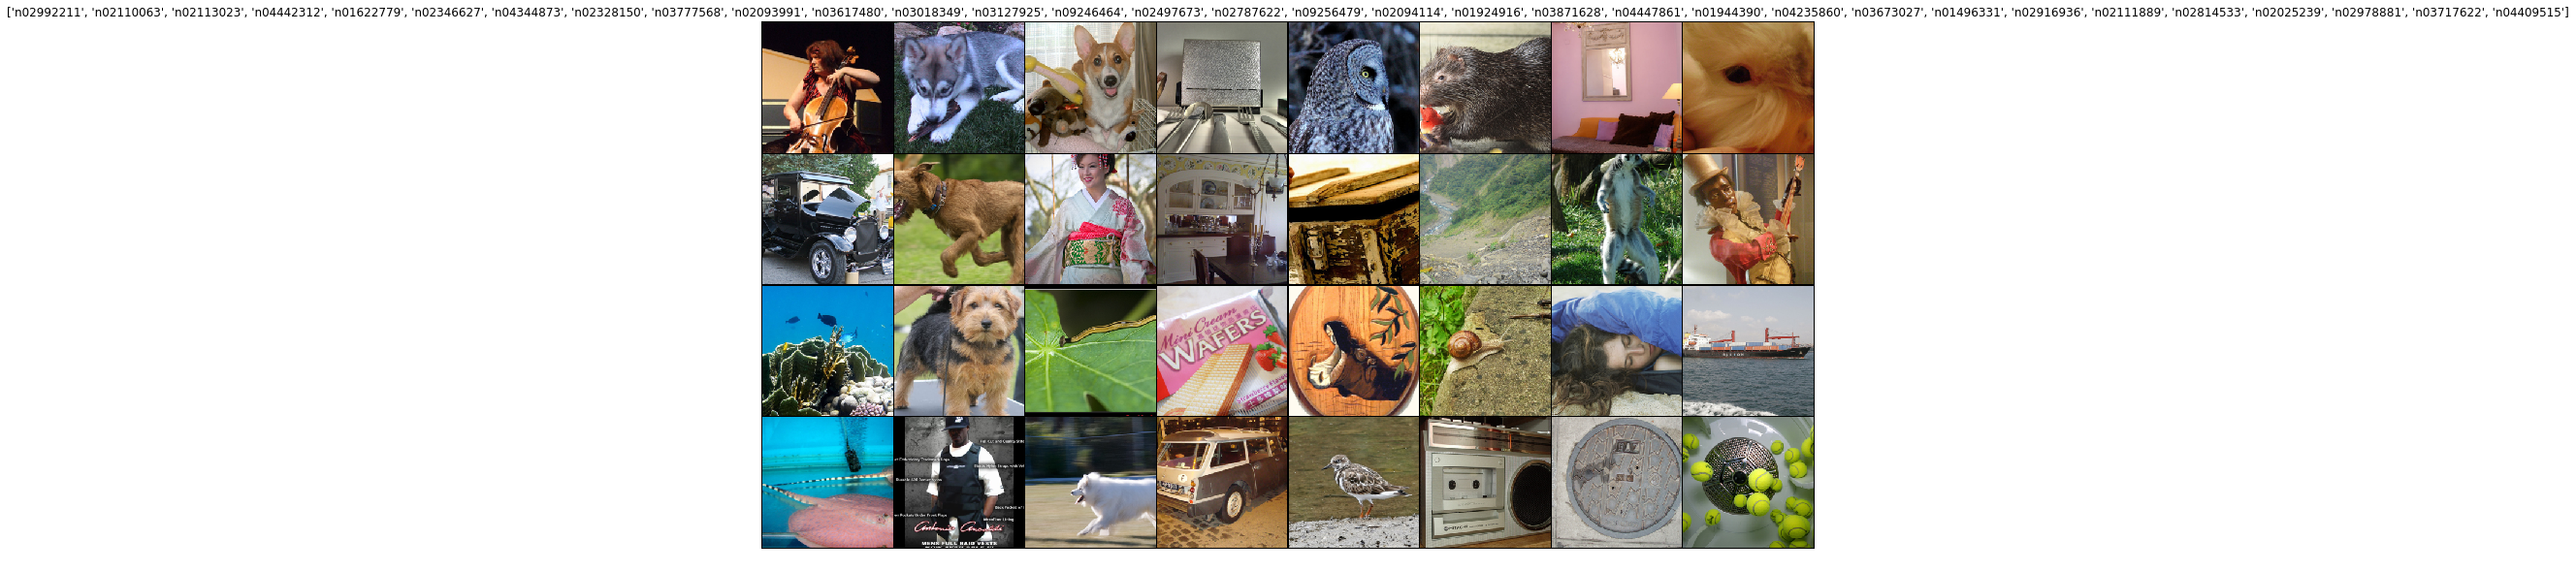

Prediction:


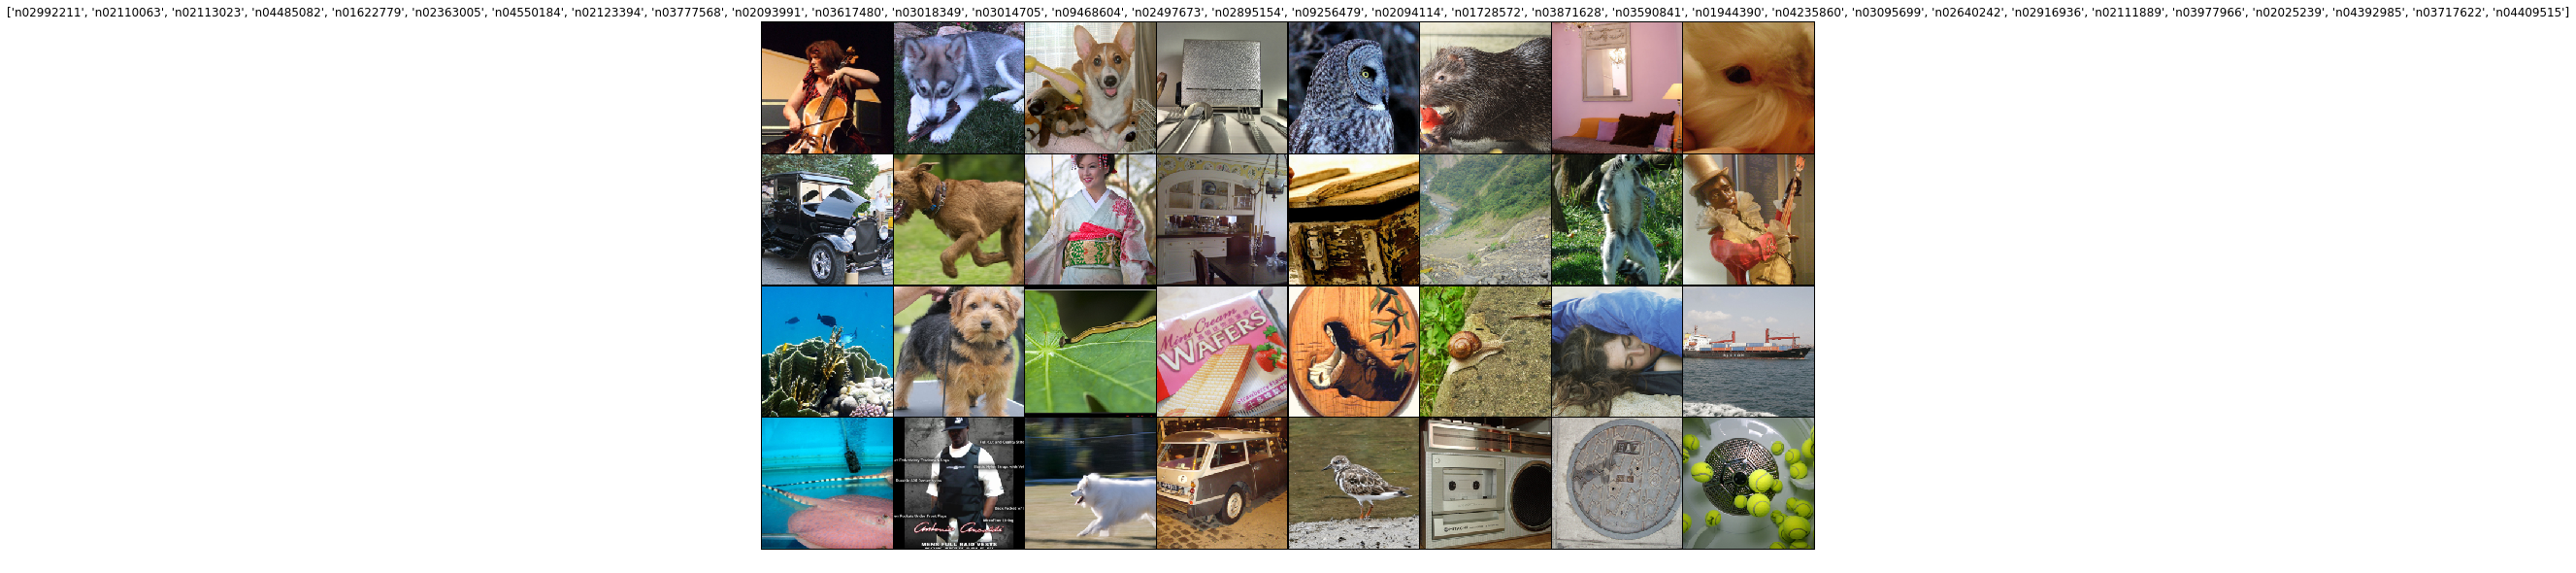

labelling equality:
[ True  True  True False  True False False False  True  True  True  True
 False False  True False  True  True False  True False  True  True False
 False  True  True False  True False  True  True]


In [10]:
visualize_model(vgg16, 8)

## Compute entropy for train and test

In [13]:
_, dataloaders, _, _ = load_imagenet(data_dir,
                           200, #batch_size
                           shuffle=True,
                           num_workers=1,
                           pin_memory=False)

Loaded 10000 images under uniform_training
Loaded 10000 images under uniform_val


In [14]:
with torch.no_grad():
    vgg16.cuda()
    scores_train = Tensor()
    scores_test = Tensor()

    for batch in tqdm(dataloaders[TRAIN]):
        scores_train = torch.cat((scores_train, vgg16(batch[0].cuda())), 0)
        
    for batch in tqdm(dataloaders[TEST]):
        scores_test = torch.cat((scores_test, vgg16(batch[0].cuda())), 0)

100%|██████████| 50/50 [01:00<00:00,  1.18s/it]


In [15]:
H_train_array = scores_train.detach().cpu().numpy()
H_test_array = scores_test.detach().cpu().numpy()

In [16]:
H_softmax_train = np.apply_along_axis(lambda r : np.exp(r)/np.sum(np.exp(r)), 1, H_train_array)
H_softmax_test = np.apply_along_axis(lambda r : np.exp(r)/np.sum(np.exp(r)), 1, H_test_array)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [17]:
H_train = np.apply_along_axis(lambda r: entropy(r), 1, H_softmax_train)
H_test = np.apply_along_axis(lambda r: entropy(r), 1, H_softmax_test)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


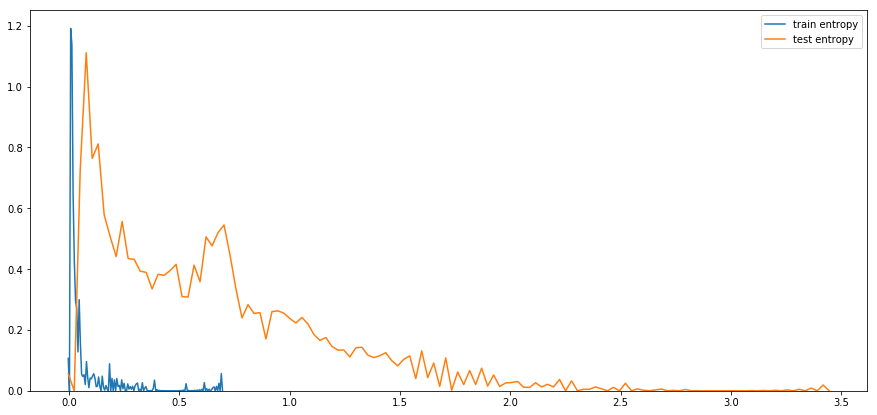

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
bw = 0.001
sns.kdeplot(H_train, bw=bw,label='train entropy', ax=ax)
sns.kdeplot(H_test,  bw=bw,label='test entropy', ax=ax)

plt.savefig("selftrained_vgg16_entropy", dpi=300)

In [19]:
dataloaders.clear()
del scores_train, scores_test, H_test_array, H_train_array, H_softmax_train, H_softmax_test, dataloaders

gc.collect()
torch.cuda.empty_cache()

### G

In [9]:
image_datasets, dataloaders, dataset_sizes, class_names= load_imagenet(data_dir,
                        32, #batch_size
                        shuffle=True,
                        num_workers=4,
                        pin_memory=False)

Loaded 10000 images under uniform_training
Loaded 10000 images under uniform_val


In [10]:
vgg16.eval()

with torch.no_grad():
    train_loader, test_loader = generate_dataloader_g(vgg16, 
                                                      dataloaders[TRAIN], 
                                                      dataloaders[TEST],
                                                      [vgg16], ['end'], cpu=False)
                                                      #[vgg16.features[28]], ['conv'], dim=64, axis=1, cpu=False)

    dataset_sizes_g = {TRAIN: len(train_loader), TEST: len(test_loader)}

313it [00:56,  5.58it/s]


In [46]:
def vgg_duh(layer_dim):
    dim = layer_dim[1]
    pool = 1
    finalVectorSize = layer_dim[2]//pool * layer_dim[3]//pool * dim
    model = nn.Sequential(
        nn.Conv2d(dim, dim, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        View([-1]),
        nn.Linear(int(finalVectorSize), 1000),
        nn.ReLU(),
        nn.Linear(1000, 2),
    )
    return model

def dense_duh():
    model = nn.Sequential(
        nn.Linear(1000, 1000),
        nn.RReLU(),
        nn.Dropout(0.5),
        nn.BatchNorm1d(1000),
        nn.Linear(1000, 1000),
        nn.RReLU(),
        nn.Dropout(0.5),
        nn.BatchNorm1d(1000),
        nn.Linear(1000, 2)
    )
    return model

def small_duh():
    model = nn.Sequential(
        nn.Linear(1000, 256),
        nn.ELU(),
        nn.Dropout(0.5),
        nn.BatchNorm1d(256),
        nn.Linear(256, 128),
        nn.ELU(),
        nn.Dropout(0.5),
        nn.BatchNorm1d(128),
        nn.Linear(128, 2)
    )
    return model

In [12]:
def vgg_block():
    model = nn.Sequential(
        #nn.BatchNorm2d(512),
        nn.MaxPool2d(2),
        View([-1]),
        nn.Linear(in_features=25088, out_features=16),
        #nn.Linear(in_features=1000, out_features=16),
        nn.RReLU(),
        #nn.Dropout(p=0.5),
        nn.BatchNorm1d(16),
        nn.Linear(in_features=16, out_features=16),
        nn.RReLU(),
        #nn.Dropout(p=0.2),
        nn.BatchNorm1d(16),
        nn.Linear(in_features=16, out_features=8),
        nn.RReLU(),
        nn.BatchNorm1d(8),
        nn.Linear(in_features=8, out_features=2),
    )
    return model

In [13]:
def VGG16ResnetG(layer_dim):
    dim = layer_dim[1]
    pad = (1, 1)
    pool = 2
    finalVectorSize = layer_dim[1]//pool * layer_dim[2]//pool * layer_dim[3]//pool
    print(finalVectorSize)
    model = nn.Sequential(
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 2)
    )
    return model

def VGG16ResnetBlock(layer_dim):
    dim0 = layer_dim[1]
    dim = 16
    pad = (1, 1)
    pool = 1
    finalVectorSize = dim//pool * layer_dim[2]//pool * layer_dim[3]//pool
    print(finalVectorSize)
    model = nn.Sequential(
        nn.Conv2d(dim0, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        #nn.Linear(32, 32),
        #nn.ReLU(),
        nn.Linear(128, 2)
    )
    return model


In [16]:
train_dataloader = DataLoader(train_loader, shuffle=True, pin_memory=False, batch_size=32)
test_dataloader = DataLoader(test_loader, shuffle=True, pin_memory=False, batch_size=32)

In [17]:
layer_dim = next(iter(train_dataloader))[0].shape
print("sample batch dimension :", layer_dim)

sample batch dimension : torch.Size([32, 1000])


In [ ]:
model = small_duh()

if use_gpu:
    model.cuda() #.cuda() will move everything to the GPU side

resume_training = False

if resume_training:
    print("Loading model..")
    model.load_state_dict(torch.load('./models/G_small_duh.pt'))
    print("Loaded!")

criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.RMSprop(model.parameters(), lr=1e-3, momentum=0.2)
optimizer_ft = optim.SGD(model.parameters(), lr=1e-2, momentum=0.2)
#optimizer_ft = optim.Adamax(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

with open('G_training_output.txt', 'w') as f:
    model, hist = train_model(model, {TRAIN: train_dataloader, TEST: test_dataloader}, \
                  criterion, optimizer_ft, exp_lr_scheduler, dataset_sizes_g, num_epochs=200, log_file=f)
    
torch.save(model.state_dict(), './models/G_small_duh.pt')

Epoch 0/200
----------
Epoch completed in 0m 3s

Validation batch 195/196
Epoch 0 result: 
Avg loss (train): 0.0217
Avg acc (train): 0.5305
Avg loss (val): 0.0213
Avg acc (val): 0.5738
----------

Epoch 1/200
----------
Epoch completed in 0m 3s

Validation batch 195/196
Epoch 1 result: 
Avg loss (train): 0.0214
Avg acc (train): 0.5592
Avg loss (val): 0.0212
Avg acc (val): 0.5696
----------

Epoch 2/200
----------
Epoch completed in 0m 3s

Validation batch 195/196
Epoch 2 result: 
Avg loss (train): 0.0213
Avg acc (train): 0.5686
Avg loss (val): 0.0210
Avg acc (val): 0.5858
----------

Epoch 3/200
----------
Epoch completed in 0m 3s

Validation batch 195/196
Epoch 3 result: 
Avg loss (train): 0.0212
Avg acc (train): 0.5739
Avg loss (val): 0.0211
Avg acc (val): 0.5797
----------

Epoch 4/200
----------
Epoch completed in 0m 3s

Validation batch 195/196
Epoch 4 result: 
Avg loss (train): 0.0211
Avg acc (train): 0.5758
Avg loss (val): 0.0210
Avg acc (val): 0.5845
----------

Epoch 5/200
---

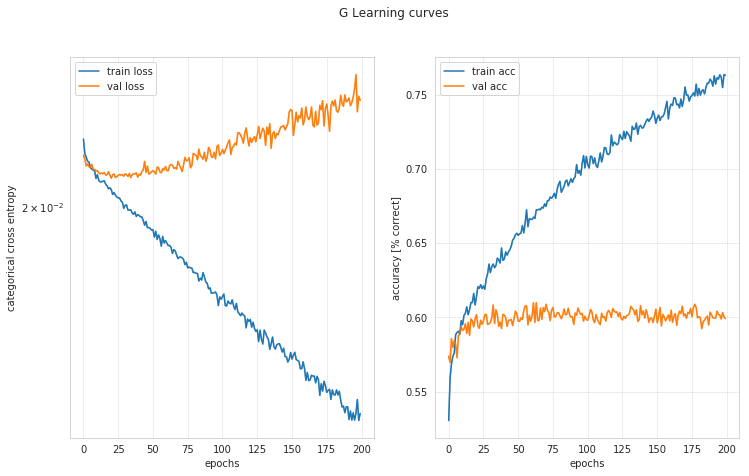

In [51]:
hist.plot("G Learning curves", 1)
plt.savefig("G_training_curves", dpi=300)

In [52]:
model.eval()
pass

false negative percentage : 44.16
false positive percentage : 36.0


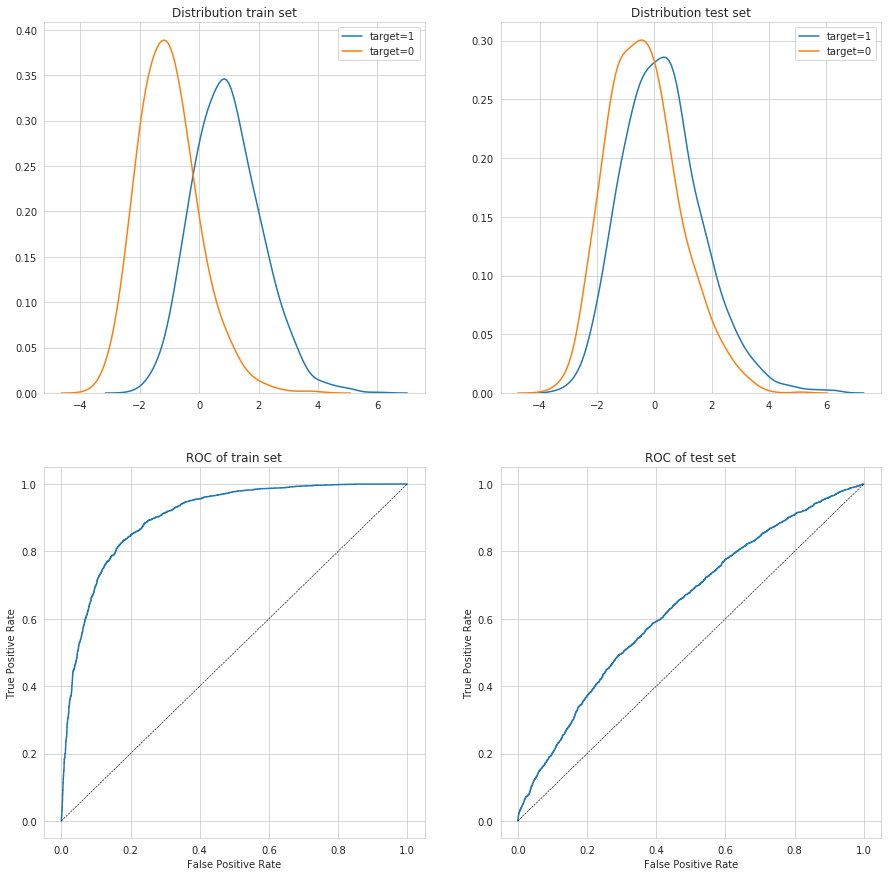


ROC score train : 0.9019518156165383
ROC score test : 0.6358385663999999


In [53]:
diagnostic_plots(model, train_dataloader, test_dataloader, bw=0.3, savefig=True)

In [45]:
#Free memory without restarting kernel
del train_loader, test_loader, dataloaders 
del train_dataloader, test_dataloader
del model, vgg16
del criterion, optimizer_ft, exp_lr_scheduler

gc.collect()
torch.cuda.empty_cache()

In [55]:
model = VGG16ResnetBlock(layer_dim)#vgg_duh(layer_dim)#VGG16ResnetG(layer_dim)#denseG(512*14*14) #kindaResnetG((1,1, 512,14,14))

if use_gpu:
    model.cuda() #.cuda() will move everything to the GPU side

resume_training = False

if resume_training:
    print("Loading model..")
    model.load_state_dict(torch.load('./models/G_vgg_resblock.pt'))
    print("Loaded!")

criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.RMSprop(model.parameters(), lr=1e-4, momentum=0.8)
optimizer_ft = optim.SGD(model.parameters(), lr=1e-2, momentum=0.2)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

with open('G_training_output.txt', 'w') as f:
    model, hist = train_model(model, {TRAIN: train_dataloader, TEST: test_dataloader}, \
                  criterion, optimizer_ft, exp_lr_scheduler, dataset_sizes_g, num_epochs=100, log_file=f)
    
torch.save(model.state_dict(), './models/G_vgg_resblock.pt')

3136
Epoch 0/100
----------
Epoch completed in 0m 3s

Validation batch 97/98
Epoch 0 result: 
Avg loss (train): 0.0108
Avg acc (train): 0.5139
Avg loss (val): 0.0108
Avg acc (val): 0.5237
----------

Epoch 1/100
----------
Epoch completed in 0m 3s

Validation batch 97/98
Epoch 1 result: 
Avg loss (train): 0.0108
Avg acc (train): 0.5609
Avg loss (val): 0.0108
Avg acc (val): 0.5274
----------

Epoch 2/100
----------
Epoch completed in 0m 3s

Validation batch 97/98
Epoch 2 result: 
Avg loss (train): 0.0107
Avg acc (train): 0.5844
Avg loss (val): 0.0108
Avg acc (val): 0.5302
----------

Epoch 3/100
----------
Epoch completed in 0m 3s

Validation batch 97/98
Epoch 3 result: 
Avg loss (train): 0.0106
Avg acc (train): 0.6001
Avg loss (val): 0.0108
Avg acc (val): 0.5322
----------

Epoch 4/100
----------
Epoch completed in 0m 3s

Validation batch 97/98
Epoch 4 result: 
Avg loss (train): 0.0104
Avg acc (train): 0.6111
Avg loss (val): 0.0109
Avg acc (val): 0.5331
----------

Epoch 5/100
--------

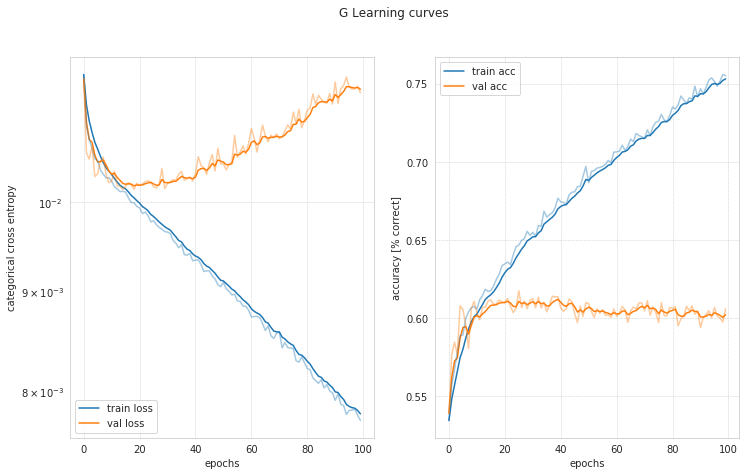

In [140]:
hist.plot("G Learning curves", 5)

false negative percentage : 39.072
false positive percentage : 39.904


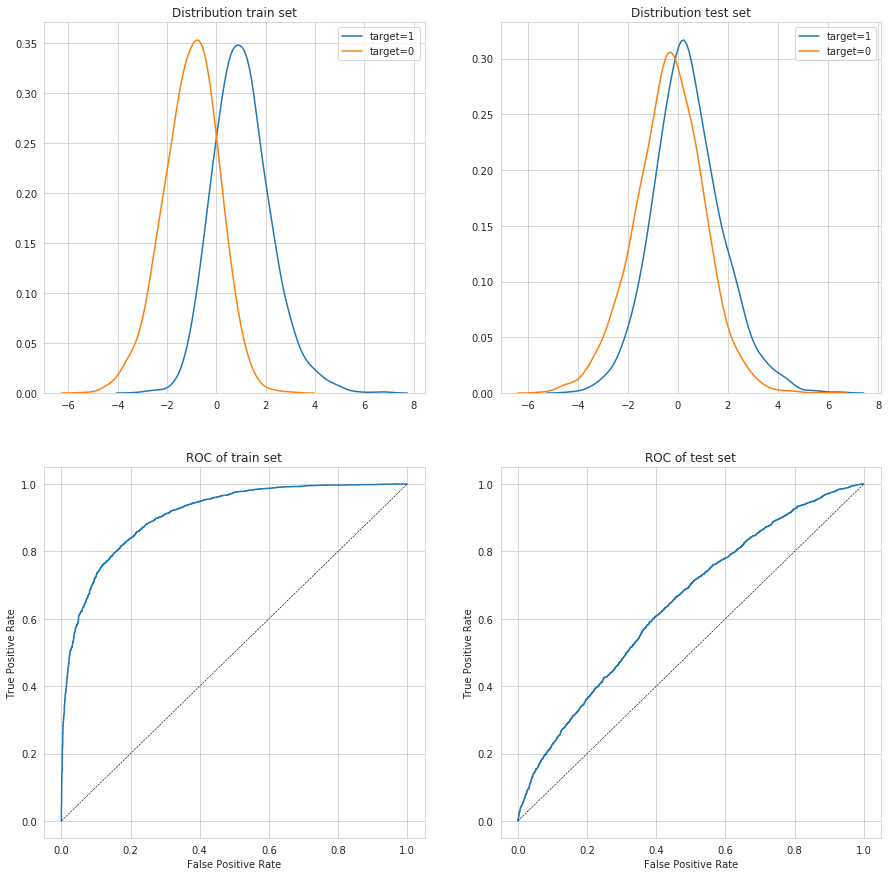


ROC score train : 0.908620383027129
ROC score test : 0.6448210432000001


In [138]:
diagnostic_plots(model, train_dataloader, test_dataloader, bw=0.3, savefig=True)

### Model visualizations

In [75]:
def visualize_model_g(vgg, dataloaders, num_images=6):
    with torch.no_grad():
        vgg.eval()
        images_so_far = 0

        for i, data in enumerate(dataloaders[TEST]):
            inputs, labels = data
            size = inputs.size()[0]

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]

            print("Ground truth:")
            inputs = (inputs - inputs.mean())/inputs.std()
            inputs = inputs[:,144:147,:,:]
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)

            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()

            images_so_far += size
            if images_so_far >= num_images:
                break

    vgg.train() # Revert model back to original training state

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth:


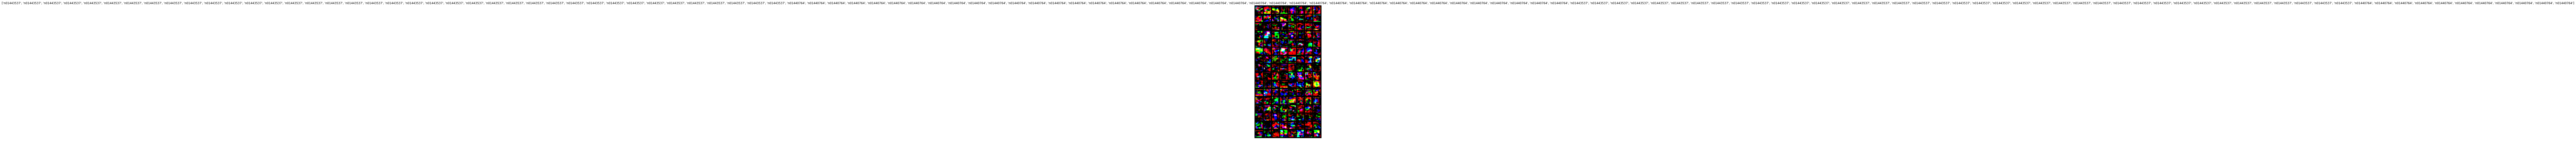

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:


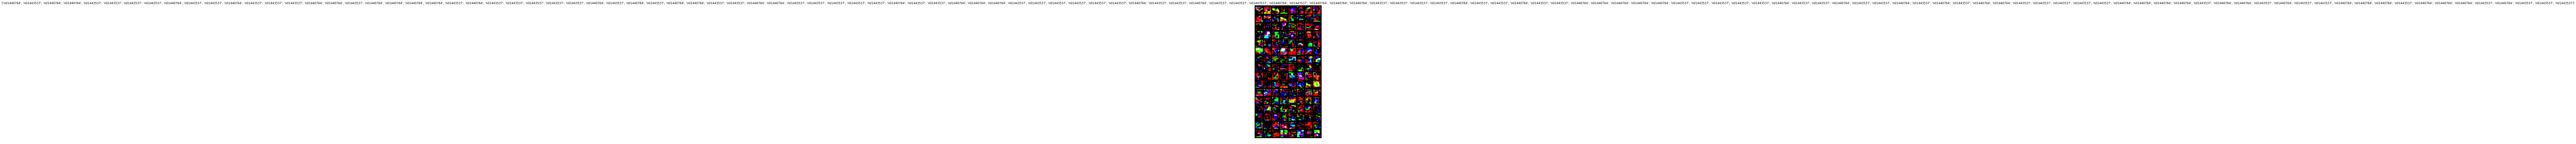

In [76]:
visualize_model_g(model, {TRAIN: train_dataloader, TEST: test_dataloader}, 8)